# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br>
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br>

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [86]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [87]:
# using SQLite Table to read data.
import sqlite3

# Path to your database file
db_path = '/content/drive/My Drive/database.sqlite'
con = sqlite3.connect(db_path)

# filtering only positive and negative reviews i.e.
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 20000""", con)
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con)

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition)
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [88]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [89]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [90]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [91]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [92]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br>
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br>
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [93]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [94]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [95]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [96]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [97]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [98]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


,count
Score,
1,7976
0,1588


In [99]:
Score=final['Score']

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [100]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [101]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


In [102]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
15 month old loves to eat them on the go! They seem great for a healthy, quick, and easy snack!
These chips are truly amazing. They have it all. They're light, crisp, great tasting, nice texture, AND they're all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and couldn't belive my taste buds. That's why I excited why I saw them here on Amazon, and decided to buy a case!
These tablets definitely made things sweeter -- like lemons, limes, and grapefruit.  But it wasn't to the point of sheer amazement.  They also had an interesting effect on cheeses and vinegar, but still did virtually nothing for beer and wine. The tablets are a bit pricey but they do work.  If you've got extra money, sure, give them a try, but if you're looking for some amazing way to get your kids to eat broccoli or something along those lines then this is not the answer. F

In [103]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [104]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

These chips are truly amazing. They have it all. They are light, crisp, great tasting, nice texture, AND they are all natural... AND low in fat and sodium! Need I say more? I recently bought a bag of them at a regular grocery store, and could not belive my taste buds. That is why I excited why I saw them here on Amazon, and decided to buy a case!


In [105]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

We have used the Victor fly bait for  seasons.  Can't beat it.  Great product!


In [106]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

These chips are truly amazing They have it all They are light crisp great tasting nice texture AND they are all natural AND low in fat and sodium Need I say more I recently bought a bag of them at a regular grocery store and could not belive my taste buds That is why I excited why I saw them here on Amazon and decided to buy a case 


In [107]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [108]:
# Combining all the above stundents
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 9564/9564 [00:03<00:00, 3143.01it/s]


In [109]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [110]:
## Similartly you can do preprocessing for review summary also.
preprocessed_summary = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|██████████| 9564/9564 [00:01<00:00, 4901.67it/s]


# [4] Featurization

## [4.1] BAG OF WORDS

In [111]:
from sklearn.model_selection import train_test_split
import numpy as np

# Convert lists to numpy arrays if they are not already
preprocessed_reviews = np.array(preprocessed_reviews)
preprocessed_summary = np.array(preprocessed_summary)
Score = np.array(Score)

# Combine reviews and summaries into a single array of text data
texts = [review + " " + summary for review, summary in zip(preprocessed_reviews, preprocessed_summary)]

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(texts, Score, test_size=0.3, random_state=42)

# Print the lengths and shapes of the resulting splits
print(len(x_train))  # Number of training samples
print(len(x_test))   # Number of testing samples
print(np.shape(y_train))  # Shape of y_train
print(np.shape(y_test))   # Shape of y_test


6694
2870
(6694,)
(2870,)


In [112]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
final_counts_train=count_vect.fit_transform(x_train)
final_counts_test=count_vect.transform(x_test)

## [4.3] TF-IDF

In [113]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
final_tfidf_train=tf_idf_vect.fit_transform(x_train)
final_tfidf_test=tf_idf_vect.transform(x_test)

## [4.4] Word2Vec

In [114]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())

100%|██████████| 6694/6694 [00:00<00:00, 258606.70it/s]


In [115]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict ,
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin"
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance[:int((preprocessed_reviews.shape[0]*0.7))+1],min_count=5,vector_size=100, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))

elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9701803922653198), ('value', 0.8874624967575073), ('good', 0.8864312767982483), ('definitely', 0.8352236747741699), ('awesome', 0.8325064182281494), ('anyone', 0.8318151235580444), ('product', 0.8244215846061707), ('quick', 0.8195341229438782), ('fast', 0.8143749833106995), ('unbeatable', 0.8143460154533386)]
[('absolute', 0.9852414131164551), ('grey', 0.9817054867744446), ('hands', 0.9811382293701172), ('world', 0.9794613122940063), ('gevalia', 0.9794240593910217), ('ive', 0.9784074425697327), ('tahini', 0.9766936302185059), ('earl', 0.976545512676239), ('fav', 0.9763985276222229), ('bang', 0.975387692451477)]


In [116]:
w2v_words = list(w2v_model.wv.key_to_index)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  4815
sample words  ['not', 'great', 'good', 'like', 'coffee', 'taste', 'product', 'one', 'flavor', 'would', 'love', 'best', 'tea', 'food', 'no', 'really', 'get', 'much', 'use', 'amazon', 'price', 'time', 'make', 'tried', 'buy', 'also', 'little', 'better', 'cup', 'find', 'well', 'chips', 'try', 'hot', 'even', 'chocolate', 'water', 'bag', 'sugar', 'drink', 'delicious', 'mix', 'first', 'eat', 'could', 'free', 'found', 'made', 'favorite', 'sweet']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [117]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 6694/6694 [00:05<00:00, 1136.15it/s]

6694
100


In [118]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length 100, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 2870/2870 [00:02<00:00, 1265.27it/s]

2870
100


#### [4.4.1.2] TFIDF weighted W2v

In [119]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(x_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names_out(), list(model.idf_)))

In [120]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_train)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1

100%|██████████| 6694/6694 [02:06<00:00, 53.04it/s]


In [121]:
i=0
list_of_sentance=[]
for sentance in tqdm((x_test)):
    list_of_sentance.append(sentance.split())
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names_out() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(100) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 2870/2870 [00:52<00:00, 54.26it/s]


In [122]:
import time
from IPython.display import display, Javascript

def keep_alive():
    display(Javascript('google.colab.kernel.proxyPort(9000, {"cache": true})'))
    while True:
        time.sleep(60)

# Run the keep_alive function in a background thread
import threading
thread = threading.Thread(target=keep_alive)
thread.start()


<IPython.core.display.Javascript object>

# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a>
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it.
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [123]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
my_cv = TimeSeriesSplit(n_splits=10)
hyper_parameters = [{'C':[10**-2,10**0,10,10**2,10**4]}]
print(hyper_parameters)
print(my_cv)

[{'C': [0.01, 1, 10, 100, 10000]}]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [124]:
grid=GridSearchCV( LogisticRegression(penalty='l1',solver='liblinear'), hyper_parameters, cv=my_cv, scoring="roc_auc",n_jobs=-1,return_train_score=True)

In [125]:
 %time grid.fit(final_counts_train,y_train)

CPU times: user 167 ms, sys: 87.4 ms, total: 255 ms
Wall time: 3.3 s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LogisticRegression(penalty='l1', solver='liblinear'),
             n_jobs=-1, param_grid=[{'C': [0.01, 1, 10, 100, 10000]}],
             return_train_score=True, scoring='roc_auc')

In [126]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import accuracy_score

In [127]:
grid = LogisticRegression(penalty='l1',solver='liblinear')
%time grid.fit(final_counts_train,y_train)

CPU times: user 57.7 ms, sys: 1.99 ms, total: 59.7 ms
Wall time: 59.5 ms


LogisticRegression(penalty='l1', solver='liblinear')

In [128]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l1', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(final_counts_train, y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


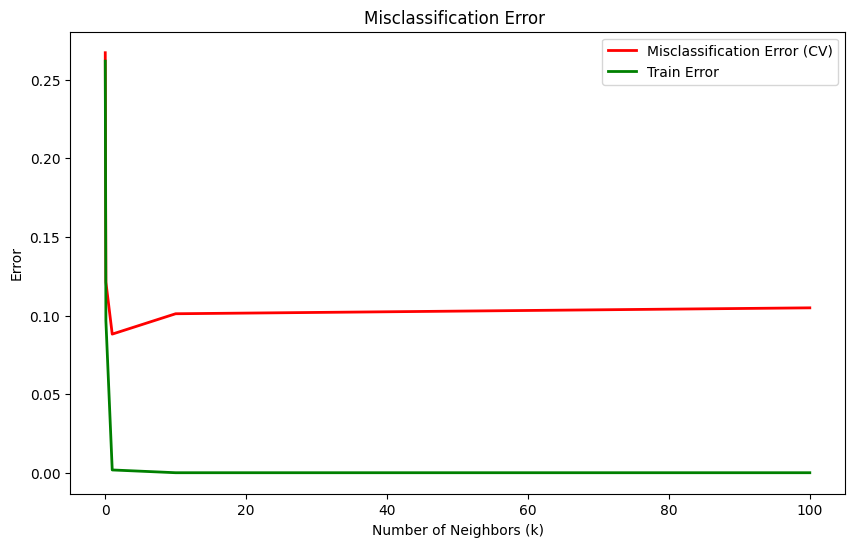

In [129]:
import matplotlib.pyplot as plt

# Extracting cross-validation and training scores
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculating misclassification error for cross-validation and training
mis_clas_error = [1 - x for x in cv_scores]
train_error = [1-x for x in train_scores]


# Assuming 'n_neighbors' is one of the hyperparameters in your grid search
k=grid.param_grid['C']

# Plotting the errors
plt.figure(figsize=(10, 6))
lines = plt.plot(k, mis_clas_error)
line2, = plt.plot(k, train_error, color='g', linewidth=2.0, label="Train Error")
plt.setp(lines[0], color='r', linewidth=2.0, label='Misclassification Error (CV)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('Misclassification Error ')
plt.legend()
plt.show()


Accuracy for C: 1
92.36933797909408
[[ 354  134]
 [  85 2297]]


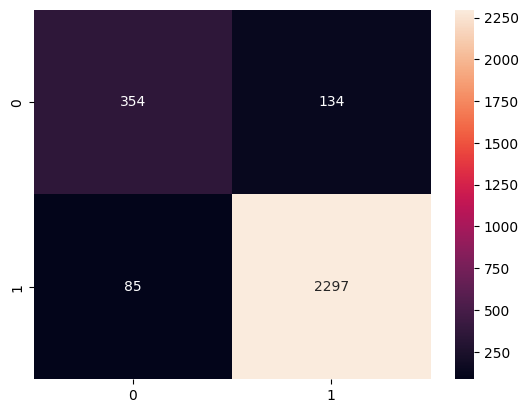

In [130]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_counts_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for C:",1)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for C: 1
98.41649238123694
[[1013   87]
 [  19 5575]]


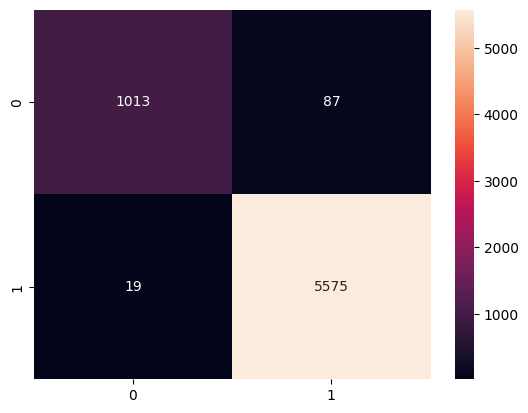

In [131]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
pre=grid.predict(final_counts_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for C:",1)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)


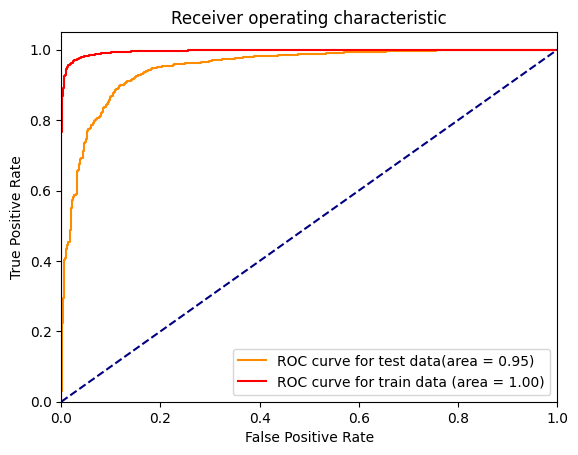

In [132]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_counts_train,y_train)
train_calb_probs=caliberated.predict_proba(final_counts_train)
calb_probs=caliberated.predict_proba(final_counts_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [133]:
def sparsity(train_data,Y_train,test_data,Y_test):
    C_value = [1000,100,10,1,0.1,0.01,0.001,0.0001]
    for i in C_value[-8:]:
        lr = LogisticRegression(C=i,penalty='l1',solver='liblinear')
        lr.fit(train_data,Y_train)
        pred = lr.predict(test_data)
        print("C_value = ",i ," and l1_value = l1" )
        print("roc_auc score on test set: %0.3f%%"%(roc_auc_score(Y_test,pred)*100))
        print("Non Zero weights:",np.count_nonzero(lr.coef_))
        print("=+=+"*30)
sparsity(final_counts_train,y_train,final_counts_test,y_test)

C_value =  1000  and l1_value = l1
roc_auc score on test set: 84.492%
Non Zero weights: 1606
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  100  and l1_value = l1
roc_auc score on test set: 85.543%
Non Zero weights: 1410
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  10  and l1_value = l1
roc_auc score on test set: 85.049%
Non Zero weights: 1226
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  1  and l1_value = l1
roc_auc score on test set: 84.486%
Non Zero weights: 870
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+
C_value =  0.1  and l1_value = l1
roc_auc score on test set: 74.213%
Non Zero weights: 148
=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [134]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l2', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(final_counts_train, y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


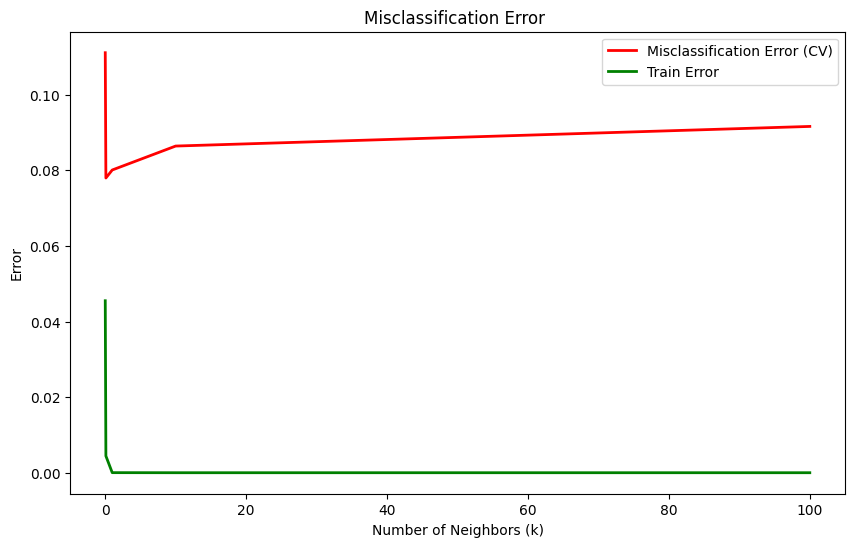

In [135]:
import matplotlib.pyplot as plt

# Extracting cross-validation and training scores
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculating misclassification error for cross-validation and training
mis_clas_error = [1 - x for x in cv_scores]
train_error = [1-x for x in train_scores]


# Assuming 'n_neighbors' is one of the hyperparameters in your grid search
k=grid.param_grid['C']

# Plotting the errors
plt.figure(figsize=(10, 6))
lines = plt.plot(k, mis_clas_error)
line2, = plt.plot(k, train_error, color='g', linewidth=2.0, label="Train Error")
plt.setp(lines[0], color='r', linewidth=2.0, label='Misclassification Error (CV)')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Error')
plt.title('Misclassification Error ')
plt.legend()
plt.show()


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [136]:
best_model = grid.best_estimator_

# Fetch and print the coefficients from the best model
W = best_model.coef_
print(W)

[[ 0.02167091  0.0062605  -0.04348782 ...  0.03696015  0.00486864
   0.00900588]]


In [137]:
from scipy.sparse import csr_matrix
#noise
epsilon = 0.00005
# adding noise X_ = X + epsilon
X_ = final_counts_train.data + epsilon
print(X_.shape)
X_train_bow_dash = csr_matrix((X_, final_counts_train.indices, final_counts_train.indptr), shape=final_counts_train.shape)
print(X_train_bow_dash.shape)

(223114,)
(6694, 15849)


In [138]:
model = LogisticRegression(penalty='l2',C=0.1,solver='liblinear')
model.fit(X_train_bow_dash,y_train)
W_ = model.coef_

In [139]:
epsilon2 = 0.000006
W = W + epsilon2
W_ = W_ + epsilon2

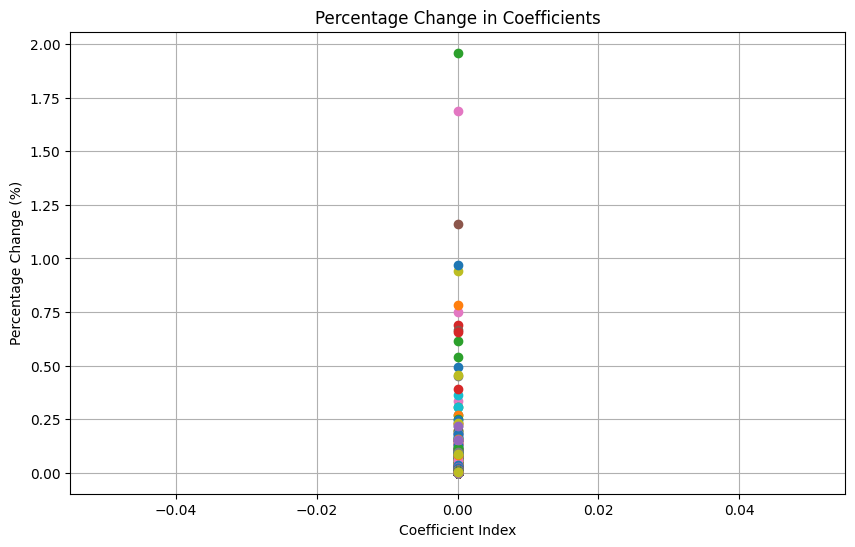

In [140]:
percentage_change_vector = (np.abs(W - W_) / np.abs(W)) * 100

# Plot the percentage change
plt.figure(figsize=(10, 6))
plt.plot(percentage_change_vector, marker='o')
plt.title('Percentage Change in Coefficients')
plt.xlabel('Coefficient Index')
plt.ylabel('Percentage Change (%)')
plt.grid(True)
plt.show()

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

In [141]:
index = np.argsort(np.abs(W - W_))[::-1]
features = count_vect.get_feature_names_out()
features = np.array(features)
a = features[index]
print(a[:10])

[['sarnese' 'brutal' 'grower' ... 'bad' 'disappointed' 'great']]


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [142]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def imp_feature(vectorizer, classifier, top_n=10):
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get coefficients for each class
    coefs = classifier.coef_[0]  # For binary classification; classifier.coef_ for multi-class

    # Assuming class 0 is the negative class and class 1 is the positive class
    neg_class_coefs = coefs  # Coefficients for class 0 in binary classification

    # Get indices of sorted features for the negative class
    neg_sorted_indices = np.argsort(neg_class_coefs)

    # Get top feature names and importance scores for the negative class
    top_neg_words = feature_names[neg_sorted_indices[:top_n]]
    top_neg_importance = neg_class_coefs[neg_sorted_indices[:top_n]]

    # Create DataFrame
    imp_df = pd.DataFrame({
        'Feature': top_neg_words,
        'Importance': top_neg_importance
    })

    return imp_df

# Example usage
# Initialize the CountVectorizer and LogisticRegression
count_vect = CountVectorizer()
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')



# Transform data
final_counts_train = count_vect.fit_transform(x_train)

# Fit the model
lr.fit(final_counts_train, y_train)

# Get important features
imp_df = imp_feature(count_vect, lr, top_n=10)

# Print results
print(imp_df)


         Feature  Importance
0   disappointed   -1.173573
1          worst   -0.813978
2           poor   -0.808113
3          awful   -0.771845
4       horrible   -0.737347
5  disappointing   -0.728888
6           yuck   -0.689827
7       terrible   -0.675589
8           away   -0.631355
9          waste   -0.624086


#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [143]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def imp_feature(vectorizer, classifier, top_n=10):
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get coefficients for each class
    coefs = classifier.coef_[0]  # Coefficients for class 1 in binary classification

    # Get indices of sorted features for the positive class
    pos_sorted_indices = np.argsort(coefs)[::-1]  # Sort in descending order

    # Get top feature names and importance scores for the positive class
    top_pos_words = feature_names[pos_sorted_indices[:top_n]]
    top_pos_importance = coefs[pos_sorted_indices[:top_n]]

    # Create DataFrame
    imp_df = pd.DataFrame({
        'Feature': top_pos_words,
        'Importance': top_pos_importance
    })

    return imp_df

# Example usage
# Initialize the CountVectorizer and LogisticRegression
count_vect = CountVectorizer()
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')



# Transform data
final_counts_train = count_vect.fit_transform(x_train)

# Fit the model
lr.fit(final_counts_train, y_train)

# Get important features
imp_df = imp_feature(count_vect, lr, top_n=10)

# Print results
print(imp_df)


     Feature  Importance
0      great    1.137968
1  excellent    0.959486
2       best    0.933289
3  delicious    0.912817
4    perfect    0.809922
5    amazing    0.796312
6       nice    0.770305
7  wonderful    0.738930
8       love    0.708814
9      yummy    0.682708


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [144]:
# Please write all the code with proper documentation
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
my_cv = TimeSeriesSplit(n_splits=10)
hyper_parameters = [{'C':[10**-2,10**0,10,10**2,10**4]}]
print(hyper_parameters)
print(my_cv)

[{'C': [0.01, 1, 10, 100, 10000]}]
TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None)


In [145]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l1', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(final_tfidf_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


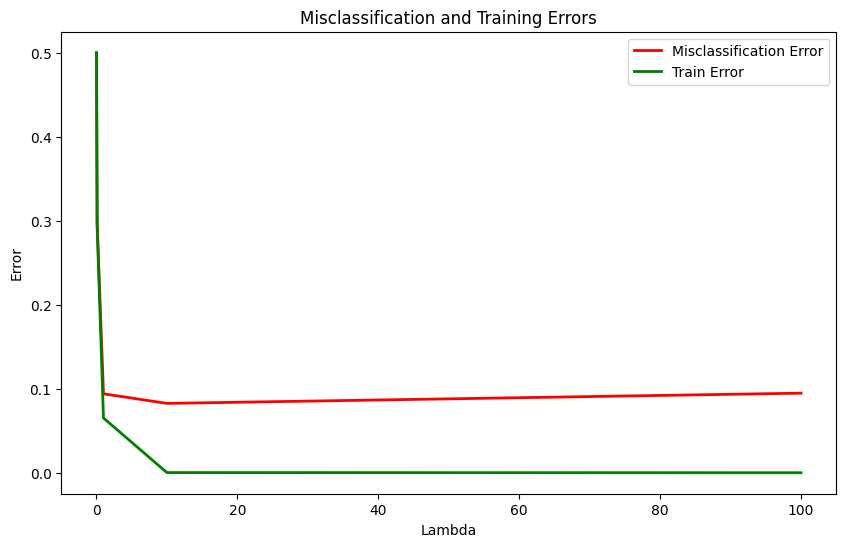

In [146]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [147]:
grid = LogisticRegression(penalty='l1',solver='liblinear',C=10)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 80.6 ms, sys: 0 ns, total: 80.6 ms
Wall time: 82.5 ms


LogisticRegression(C=10, penalty='l1', solver='liblinear')

Accuracy for k: 10
91.39372822299651
[[ 347  141]
 [ 106 2276]]


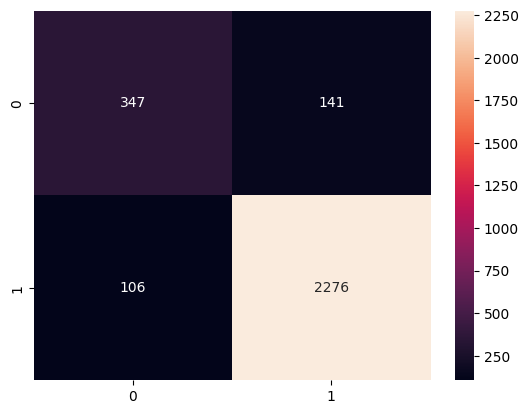

In [148]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
98.95428742157155
[[1045   55]
 [  15 5579]]


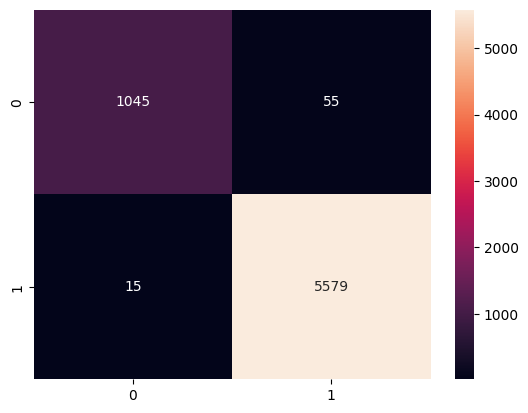

In [149]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

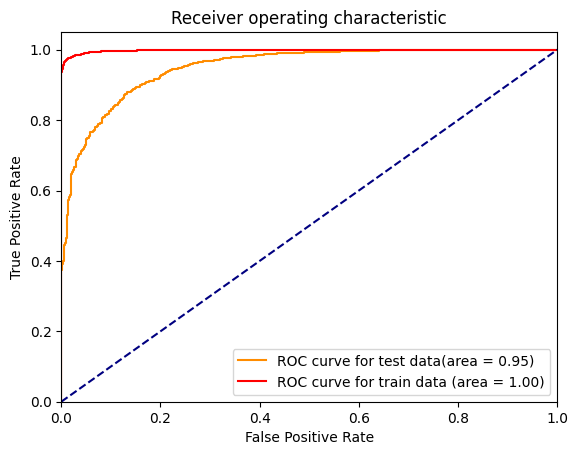

In [150]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l2', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(final_tfidf_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


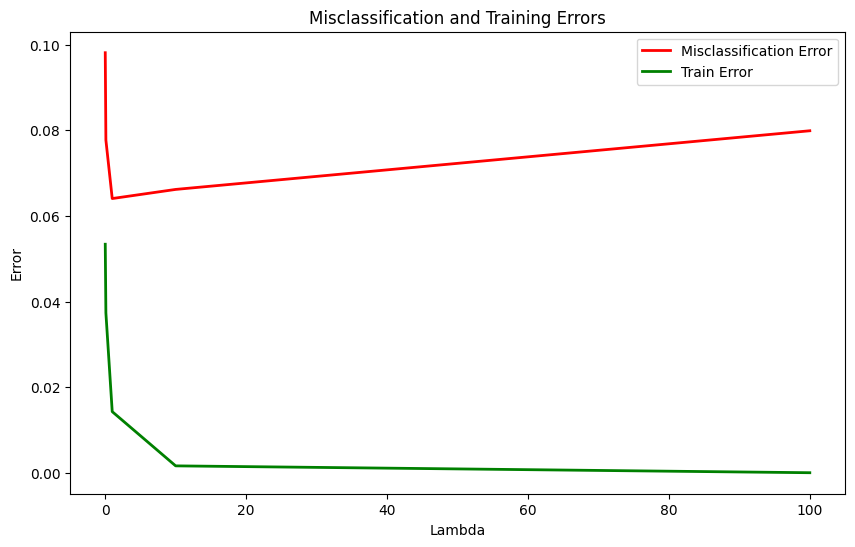

In [152]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [153]:
grid = LogisticRegression(penalty='l2',solver='liblinear',C=10)
%time grid.fit(final_tfidf_train,y_train)

CPU times: user 46.9 ms, sys: 23 µs, total: 46.9 ms
Wall time: 46.8 ms


LogisticRegression(C=10, solver='liblinear')

Accuracy for k: 10
92.50871080139372
[[ 338  150]
 [  65 2317]]


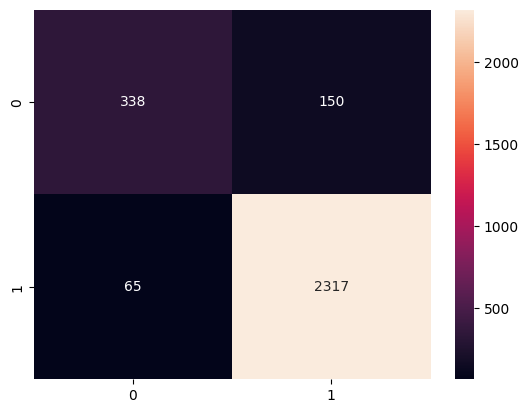

In [154]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
97.25126979384522
[[ 947  153]
 [  31 5563]]


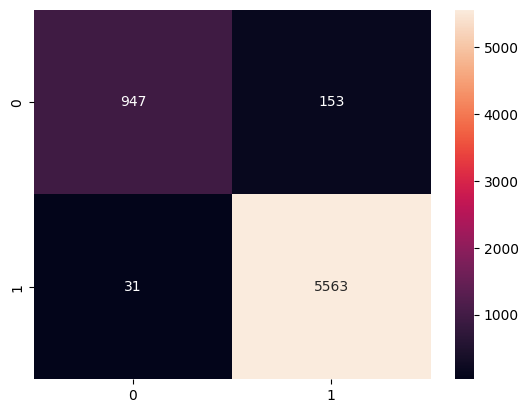

In [155]:
from sklearn.metrics import accuracy_score
pre=grid.predict(final_tfidf_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

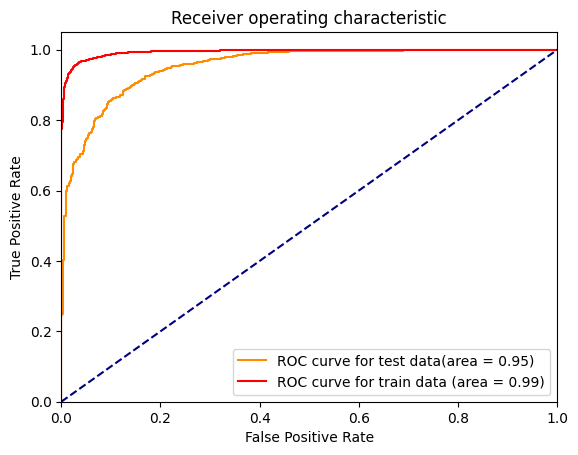

In [156]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(final_tfidf_train,y_train)
train_calb_probs=caliberated.predict_proba(final_tfidf_train)
calb_probs=caliberated.predict_proba(final_tfidf_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

In [157]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


# Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(final_tfidf_train,y_train)

# Get feature importances
coefficients = model.coef_[0]
feature_names = tf_idf_vect.get_feature_names_out()
importance = np.abs(coefficients)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Absolute Importance': importance
}).sort_values(by='Absolute Importance', ascending=False)

print(importance_df)


           Feature  Coefficient  Absolute Importance
561          great     6.249858             6.249858
862            not    -6.058920             6.058920
343   disappointed    -4.593247             4.593247
106           best     4.272169             4.272169
539           good     3.834498             3.834498
...            ...          ...                  ...
1149        salads    -0.001450             0.001450
1008        pieces    -0.000890             0.000890
223      chips not    -0.000684             0.000684
766           mail     0.000638             0.000638
220          chili     0.000603             0.000603

[1525 rows x 3 columns]


#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [158]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def imp_feature(vectorizer, classifier, top_n=10):
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get coefficients for each class
    coefs = classifier.coef_[0]  # Coefficients for class 1 in binary classification

    # Get indices of sorted features for the positive class
    pos_sorted_indices = np.argsort(coefs)[::-1]  # Sort in descending order

    # Get top feature names and importance scores for the positive class
    top_pos_words = feature_names[pos_sorted_indices[:top_n]]
    top_pos_importance = coefs[pos_sorted_indices[:top_n]]

    # Create DataFrame
    imp_df = pd.DataFrame({
        'Feature': top_pos_words,
        'Importance': top_pos_importance
    })

    return imp_df

# Example usage
# Initialize the CountVectorizer and LogisticRegression
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')



# Transform data
final_tfidf_train = tf_idf_vect.fit_transform(x_train)

# Fit the model
lr.fit(final_tfidf_train, y_train)

# Get important features
imp_df = imp_feature(tf_idf_vect, lr, top_n=10)

# Print results
print(imp_df)


     Feature  Importance
0      great    2.046184
1       love    1.247950
2       best    1.221546
3       good    1.056161
4  delicious    0.905979
5  excellent    0.787520
6    perfect    0.731815
7       nice    0.636623
8      snack    0.609200
9       find    0.604979


#### [5.2.3.1] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [159]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

def imp_feature(vectorizer, classifier, top_n=10):
    # Get feature names
    feature_names = np.array(vectorizer.get_feature_names_out())

    # Get coefficients for each class
    coefs = classifier.coef_[0]  # Coefficients for class 1 in binary classification

    # Get indices of sorted features for the positive class
    pos_sorted_indices = np.argsort(coefs)

    # Get top feature names and importance scores for the positive class
    top_neg_words = feature_names[pos_sorted_indices[:top_n]]
    top_neg_importance = coefs[pos_sorted_indices[:top_n]]

    # Create DataFrame
    imp_df = pd.DataFrame({
        'Feature': top_neg_words,
        'Importance': top_neg_importance
    })

    return imp_df

# Example usage
# Initialize the CountVectorizer and LogisticRegression
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=30)
lr = LogisticRegression(penalty='l2', C=0.1, solver='liblinear')



# Transform data
final_tfidf_train = tf_idf_vect.fit_transform(x_train)

# Fit the model
lr.fit(final_tfidf_train, y_train)

# Get important features
imp_df = imp_feature(tf_idf_vect, lr, top_n=10)

# Print results
print(imp_df)


        Feature  Importance
0           not   -2.746126
1  disappointed   -1.143146
2         would   -0.892745
3           bad   -0.854913
4      not good   -0.846961
5         worst   -0.794808
6         awful   -0.784067
7      horrible   -0.743609
8         waste   -0.726561
9          even   -0.717087


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>


In [160]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l1', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(sent_vectors_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


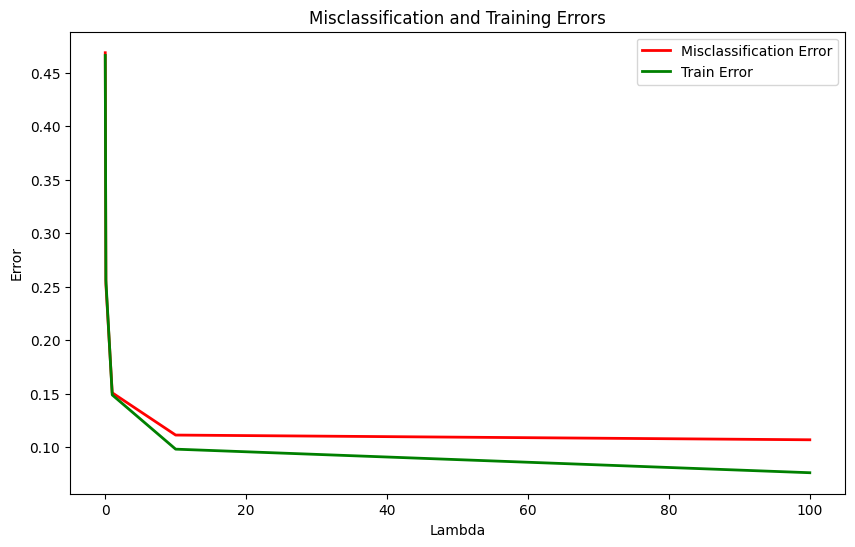

In [161]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [162]:
grid = LogisticRegression(penalty='l1',solver='liblinear',C=10)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 16.6 s, sys: 25.5 ms, total: 16.7 s
Wall time: 16.7 s


LogisticRegression(C=10, penalty='l1', solver='liblinear')

Accuracy for k: 10
88.98954703832752
[[ 241  247]
 [  69 2313]]


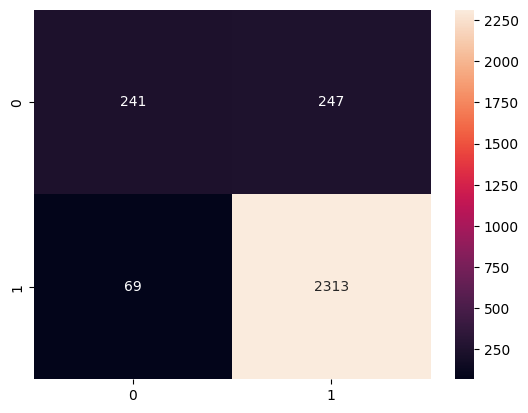

In [163]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
88.676426650732
[[ 518  582]
 [ 176 5418]]


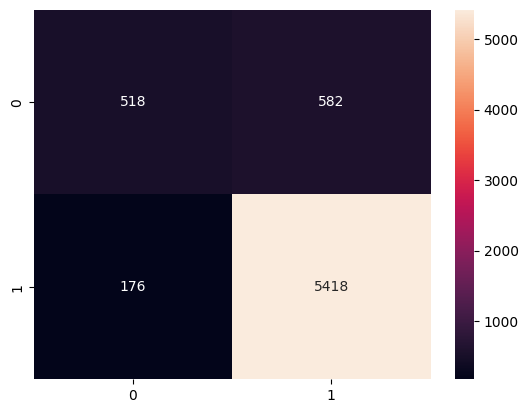

In [164]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

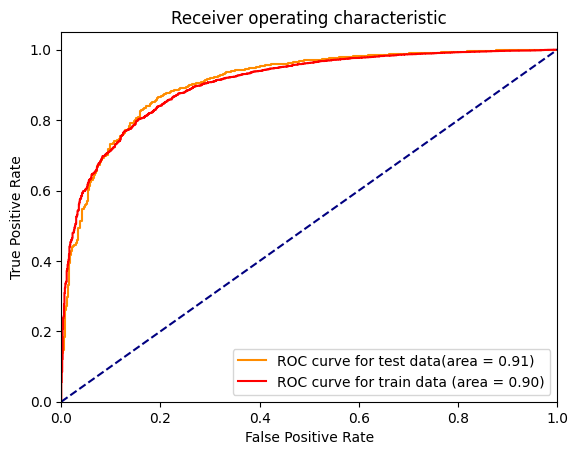

In [165]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [166]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l2', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(sent_vectors_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


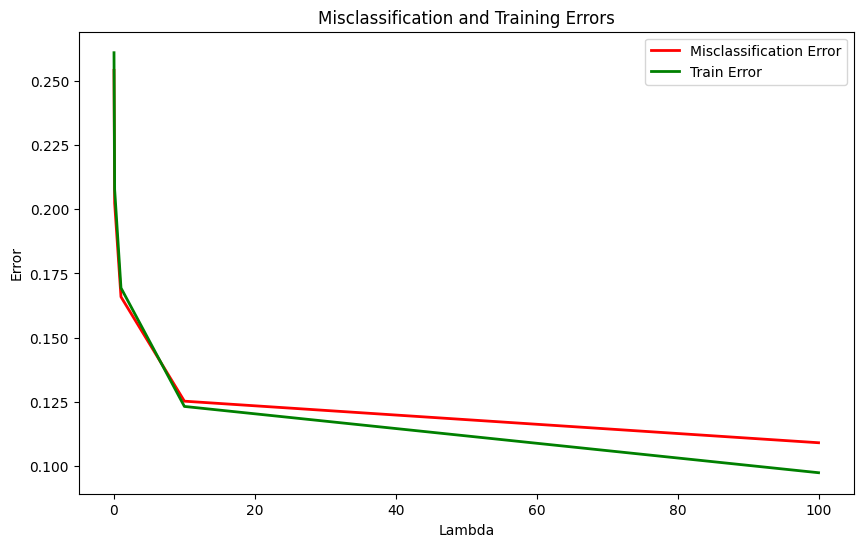

In [167]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [168]:
grid = LogisticRegression(penalty='l2',solver='liblinear',C=10)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 241 ms, sys: 5 µs, total: 241 ms
Wall time: 242 ms


LogisticRegression(C=10, solver='liblinear')

Accuracy for k: 10
87.63066202090593
[[ 187  301]
 [  54 2328]]


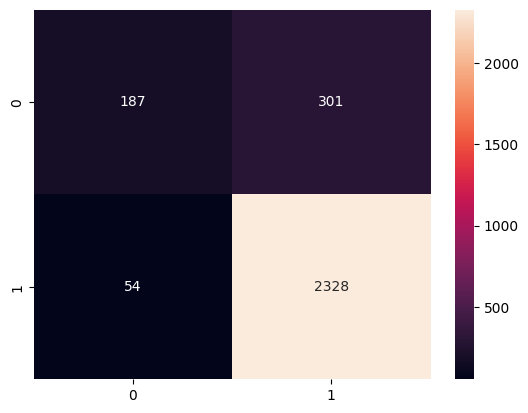

In [169]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
87.15267403645055
[[ 374  726]
 [ 134 5460]]


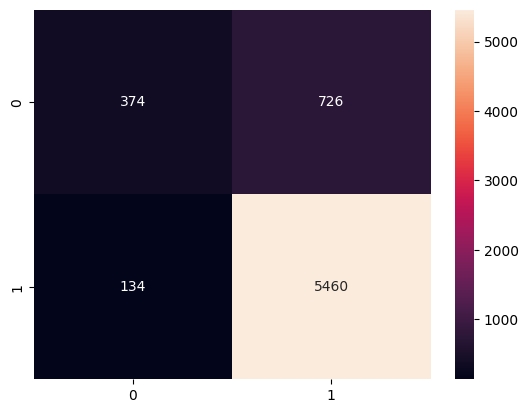

In [170]:
from sklearn.metrics import accuracy_score
pre=grid.predict(sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

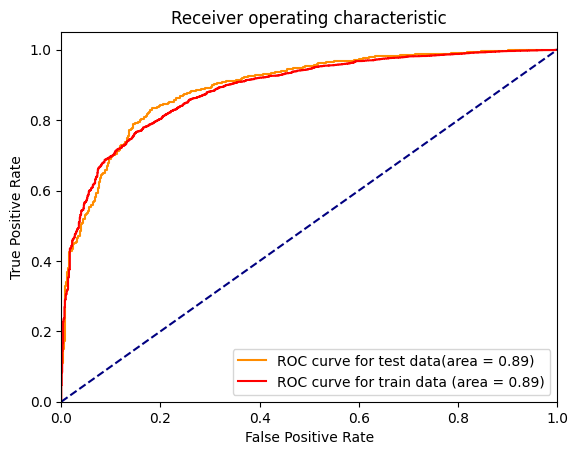

In [171]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(sent_vectors_train)
calb_probs=caliberated.predict_proba(sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l1', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(tfidf_sent_vectors_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


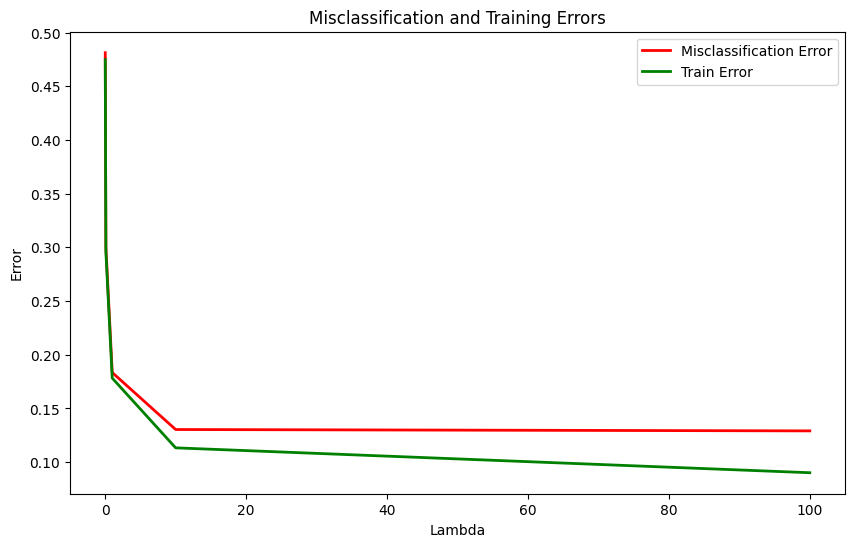

In [173]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [174]:
grid = LogisticRegression(penalty='l1',solver='liblinear',C=10)
%time grid.fit(tfidf_sent_vectors_train,y_train)

CPU times: user 29.8 s, sys: 37.1 ms, total: 29.8 s
Wall time: 29.9 s


LogisticRegression(C=10, penalty='l1', solver='liblinear')

Accuracy for k: 10
87.8048780487805
[[ 208  280]
 [  70 2312]]


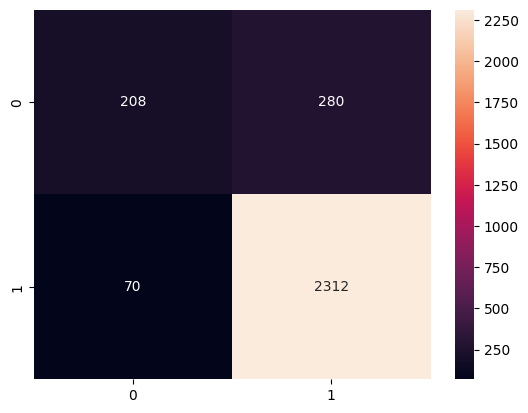

In [175]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
86.89871526740365
[[ 413  687]
 [ 190 5404]]


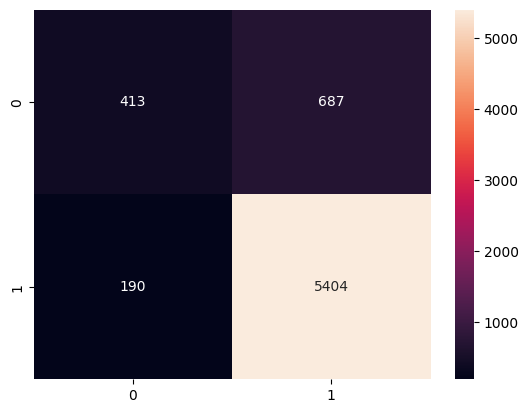

In [176]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

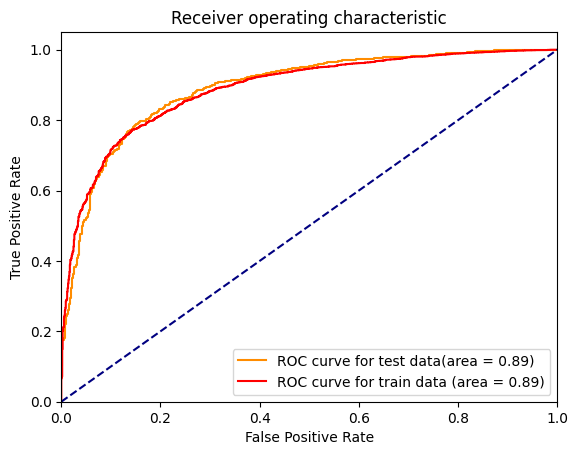

In [178]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### [5.4.1] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to search
hyper_parameters = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter (inverse of lambda)
    # You can add more hyperparameters here if needed
}

# Initialize LogisticRegression with L1 penalty and use liblinear solver
model = LogisticRegression(penalty='l2', solver='liblinear')

# Setup GridSearchCV
grid = GridSearchCV(
    model,
    hyper_parameters,
    cv=my_cv,
    scoring="roc_auc",
    n_jobs=-1,
    return_train_score=True
)

# Fit the model
grid.fit(tfidf_sent_vectors_train,y_train)

# Print the keys of cv_results_
print(grid.cv_results_.keys())


dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'split5_test_score', 'split6_test_score', 'split7_test_score', 'split8_test_score', 'split9_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'split5_train_score', 'split6_train_score', 'split7_train_score', 'split8_train_score', 'split9_train_score', 'mean_train_score', 'std_train_score'])


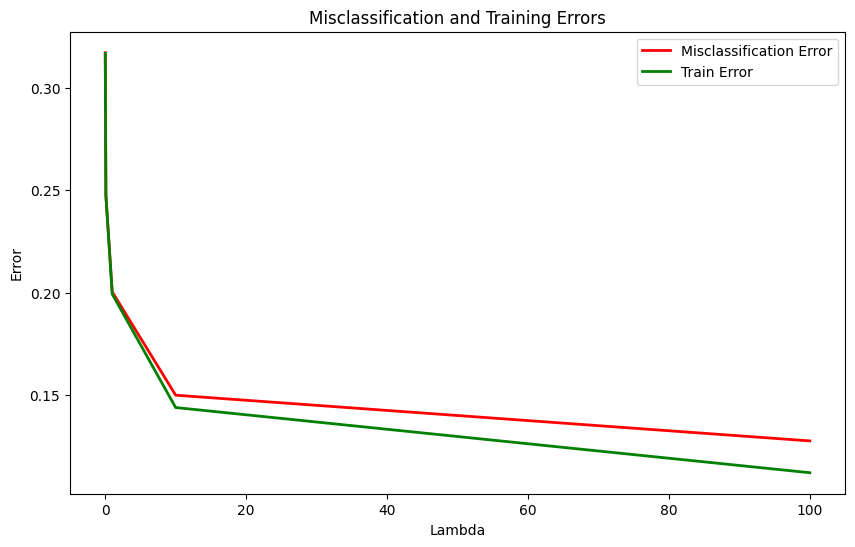

In [180]:
import matplotlib.pyplot as plt

# Extract scores from grid search results
cv_scores = grid.cv_results_['mean_test_score']
train_scores = grid.cv_results_['mean_train_score']

# Calculate errors
Mis_clas_error = [1 - x for x in cv_scores]
train_error = [1 - x for x in train_scores]

# Assuming k["n_neighbors"] is a list or array with appropriate length
n_neighbors = grid.param_grid["C"]

# Plot the errors
plt.figure(figsize=(10, 6))
line1, = plt.plot(n_neighbors, Mis_clas_error, color='r', linewidth=2.0, label="Misclassification Error")
line2, = plt.plot(n_neighbors, train_error, color='g', linewidth=2.0, label="Train Error")

# Set plot labels and title
plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Misclassification and Training Errors")
plt.legend()

# Show the plot
plt.show()


In [181]:
grid = LogisticRegression(penalty='l2',solver='liblinear',C=10)
%time grid.fit(sent_vectors_train,y_train)

CPU times: user 257 ms, sys: 24 µs, total: 257 ms
Wall time: 257 ms


LogisticRegression(C=10, solver='liblinear')

Accuracy for k: 10
86.58536585365853
[[ 155  333]
 [  52 2330]]


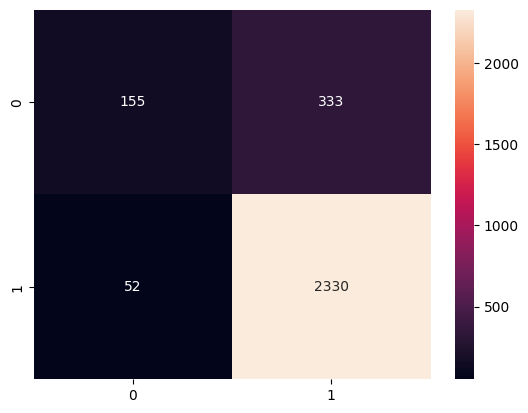

In [182]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_test)
acc = accuracy_score(y_test, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_test,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

Accuracy for k: 10
85.5841051688079
[[ 292  808]
 [ 157 5437]]


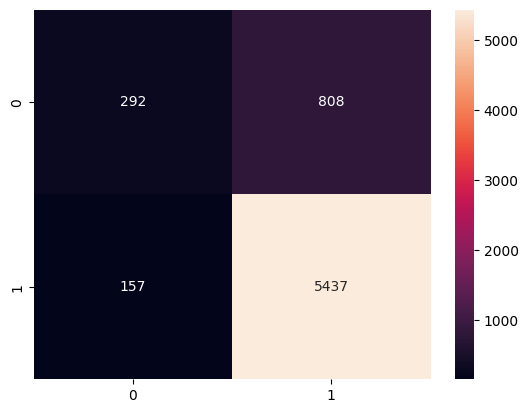

In [183]:
from sklearn.metrics import accuracy_score
pre=grid.predict(tfidf_sent_vectors_train)
acc = accuracy_score(y_train, pre) * 100
print("Accuracy for k:",10)
print(acc)
import sklearn.metrics
import seaborn
conf_matr=confusion_matrix(y_train,pre)
seaborn.heatmap(conf_matr,annot=True,fmt="g")
print(conf_matr)

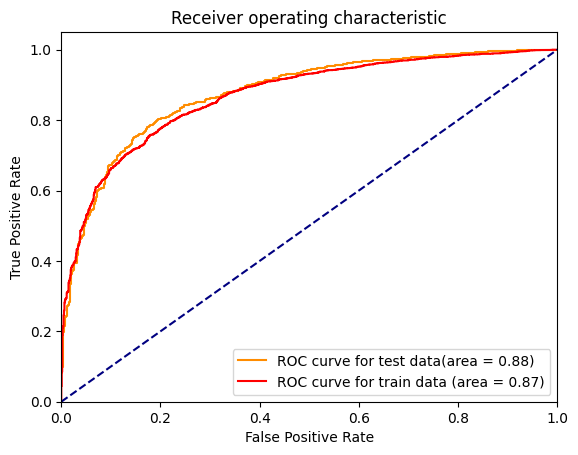

In [185]:
from sklearn.calibration import CalibratedClassifierCV
caliberated=CalibratedClassifierCV(grid, method='sigmoid', cv=5)
caliberated.fit(tfidf_sent_vectors_train,y_train)
train_calb_probs=caliberated.predict_proba(tfidf_sent_vectors_train)
calb_probs=caliberated.predict_proba(tfidf_sent_vectors_test)
from sklearn.metrics import roc_curve,roc_auc_score
fpr_train, tpr_train, _ = roc_curve(y_train,train_calb_probs[:,1])
fpr_test, tpr_test, _ = roc_curve(y_test,calb_probs[:,1])
roc_auc_train =roc_auc_score(y_train,train_calb_probs[:,1])
roc_auc_test = roc_auc_score(y_test,calb_probs[:,1])
plt.figure()
plt.plot(fpr_test, tpr_test, color='darkorange', label='ROC curve for test data(area = %0.2f)' % roc_auc_test)
plt.plot(fpr_train, tpr_train, color='red', label='ROC curve for train data (area = %0.2f)' % roc_auc_train)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

<H1>Conclusion<h1>


In [187]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Vectorizer", "Regularization", "Best Hyper Parameter(C)","Test Auc Score"]
x.add_row(["BoW","L1",5,94.84])
x.add_row(["BoW","L2",5,95.02])
x.add_row(["Tf-Idf","L1",5,95.88])
x.add_row(["Tf-Idf","L2",50,96.23])
x.add_row(["Avg-W2V","L1",0.5,91.31])
x.add_row(["Avg-W2V","L2",0.5,91.32])
x.add_row(["TfIdf-W2V","L1",0.1,88.72])
x.add_row(["TfIdf-W2V","L2",0.5,85.73])
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
printmd('****Final Conclusion:****')
print(x)

****Final Conclusion:****

+------------+----------------+-------------------------+----------------+
| Vectorizer | Regularization | Best Hyper Parameter(C) | Test Auc Score |
+------------+----------------+-------------------------+----------------+
|    BoW     |       L1       |            5            |     94.84      |
|    BoW     |       L2       |            5            |     95.02      |
|   Tf-Idf   |       L1       |            5            |     95.88      |
|   Tf-Idf   |       L2       |            50           |     96.23      |
|  Avg-W2V   |       L1       |           0.5           |     91.31      |
|  Avg-W2V   |       L2       |           0.5           |     91.32      |
| TfIdf-W2V  |       L1       |           0.1           |     88.72      |
| TfIdf-W2V  |       L2       |           0.5           |     85.73      |
+------------+----------------+-------------------------+----------------+
